<a href="https://colab.research.google.com/github/enitin-agarwal/azureforaws/blob/master/ChurnGuardAIMLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# -*- coding: utf-8 -*-
"""
File: data_generator.py
Desc: Generates sophisticated, persona-based synthetic customer data
      for the ChurnGuard AI project. This script provides the
      "evidence" for the synthetic data evaluation.
"""

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from pathlib import Path

# --- Configuration ---
NUM_CUSTOMERS = 200
SIMULATION_DAYS = 90
OUTPUT_DIR = Path("./churn_data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Customer Personas ---
# Defines the *latent* (hidden) behavior of different customer types.
CUSTOMER_PERSONAS = {
    "loyalist": {
        "base_churn_propensity": 0.05,
        "purchase_value_mean": 150,
        "purchase_value_std": 30,
        "review_sentiment": 0.7, # (0=neg, 1=pos)
        "support_ticket_freq": 0.1,
        "login_freq_mean": 12, # hours/week
        "frustration_sensitivity": 0.2 # How much a bad event increases churn risk
    },
    "price_sensitive_newbie": {
        "base_churn_propensity": 0.4,
        "purchase_value_mean": 40,
        "purchase_value_std": 10,
        "review_sentiment": 0.4,
        "support_ticket_freq": 0.3,
        "login_freq_mean": 5,
        "frustration_sensitivity": 0.6
    },
    "disappointed_power_user": {
        "base_churn_propensity": 0.2,
        "purchase_value_mean": 250,
        "purchase_value_std": 50,
        "review_sentiment": 0.3,
        "support_ticket_freq": 0.5, # High support usage
        "login_freq_mean": 20,
        "frustration_sensitivity": 0.8
    },
    "silent_churner": {
        "base_churn_propensity": 0.3,
        "purchase_value_mean": 70,
        "purchase_value_std": 20,
        "review_sentiment": 0.5, # Tends to not leave reviews
        "support_ticket_freq": 0.05, # Doesn't complain
        "login_freq_mean": 8,
        "frustration_sensitivity": 0.5
    }
}

# --- Text Generation Templates ---
REVIEW_TEMPLATES = {
    "positive": [
        "Absolutely love this! Best purchase I've made all year.",
        "Works perfectly, exactly as described. 5 stars.",
        "Great value and fast shipping. Will buy from here again.",
        "Fantastic product. Highly recommended.",
        "My new favorite thing. So happy with this."
    ],
    "neutral": [
        "It's okay. Does the job but wasn't amazing.",
        "Product is as described. Shipping was a bit slow.",
        "Average quality for an average price. It's fine.",
        "No complaints, but not thrilled either.",
        "The item is functional."
    ],
    "negative": [
        "Extremely frustrated. Arrived broken and support is no help.",
        "This is not what I ordered! Awful quality.",
        "Waited 3 weeks for this? What a joke. Never again.",
        "Doesn't work. Complete waste of money. Trying to get a refund.",
        "Terrible experience. The website is confusing and support is useless."
    ]
}

def generate_review_text(sentiment_score, urgency):
    """Generates a review based on a sentiment score and urgency."""
    if urgency > 8:
        return random.choice(REVIEW_TEMPLATES["negative"])
    if sentiment_score > 0.6:
        return random.choice(REVIEW_TEMPLATES["positive"])
    if sentiment_score < 0.3:
        return random.choice(REVIEW_TEMPLATES["negative"])
    return random.choice(REVIEW_TEMPLATES["neutral"])

def simulate_customer_journey():
    """Simulates the full journey for all customers."""

    customers_data = []
    interactions_data = []
    reviews_data = []

    start_date = datetime.now().date() - timedelta(days=SIMULATION_DAYS)

    for i in range(NUM_CUSTOMERS):
        customer_id = f"CUST_{i:04d}"
        persona_name = random.choice(list(CUSTOMER_PERSONAS.keys()))
        persona = CUSTOMER_PERSONAS[persona_name]

        # Latent (hidden) states
        latent_churn_propensity = persona["base_churn_propensity"]
        latent_satisfaction = persona["review_sentiment"]

        customers_data.append({
            "customer_id": customer_id,
            "persona": persona_name,
            "age_of_account_days": SIMULATION_DAYS
        })

        current_purchase_value = persona["purchase_value_mean"]
        current_login_freq = persona["login_freq_mean"]

        for day in range(SIMULATION_DAYS):
            date = start_date + timedelta(days=day)

            # Simulate a "bad event" (e.g., late shipping, bad support)
            bad_event_today = random.random() < (persona["support_ticket_freq"] * 0.5)

            # Update latent states
            if bad_event_today:
                latent_satisfaction -= persona["frustration_sensitivity"] * 0.5
                latent_churn_propensity += persona["frustration_sensitivity"]
            else:
                # Slight regression to the mean
                latent_satisfaction = latent_satisfaction * 0.95 + persona["review_sentiment"] * 0.05
                latent_churn_propensity = latent_churn_propensity * 0.95 + persona["base_churn_propensity"] * 0.05

            latent_churn_propensity = np.clip(latent_churn_propensity, 0.01, 0.99)
            latent_satisfaction = np.clip(latent_satisfaction, 0.01, 0.99)

            # --- Generate observable data based on latent states ---

            # Did they log in?
            login_today = random.random() < (current_login_freq / 7)
            if login_today:
                interactions_data.append({
                    "customer_id": customer_id,
                    "date": date,
                    "interaction_type": "login",
                    "value": 1
                })
                # Update current login freq (drifts towards latent state)
                current_login_freq = current_login_freq * 0.9 + (persona["login_freq_mean"] * (latent_satisfaction)) * 0.1

            # Did they buy something?
            purchase_today = login_today and random.random() < (0.1 * (1 - latent_churn_propensity))
            if purchase_today:
                purchase_value = max(10, random.normalvariate(persona["purchase_value_mean"], persona["purchase_value_std"]))
                purchase_value *= (1.5 * latent_satisfaction) # Happy customers spend more
                current_purchase_value = purchase_value

                interactions_data.append({
                    "customer_id": customer_id,
                    "date": date,
                    "interaction_type": "purchase",
                    "value": round(purchase_value, 2)
                })

            # Did they file a support ticket?
            support_ticket_today = bad_event_today or (random.random() < persona["support_ticket_freq"] * (1 - latent_satisfaction))
            if support_ticket_today and persona_name != "silent_churner":
                urgency = random.randint(5, 10) if bad_event_today else random.randint(1, 6)
                interactions_data.append({
                    "customer_id": customer_id,
                    "date": date,
                    "interaction_type": "support_ticket",
                    "value": urgency # 1-10 urgency scale
                })

            # Did they leave a review?
            review_today = (purchase_today or support_ticket_today) and random.random() < 0.3 # 30% chance to review
            if review_today and persona_name != "silent_churner":
                # Fix: Check if interactions_data is not empty before accessing index -1
                review_urgency = interactions_data[-1]["value"] if (support_ticket_today and interactions_data) else 0
                review_sentiment_score = latent_satisfaction
                review_text = generate_review_text(review_sentiment_score, review_urgency)

                reviews_data.append({
                    "review_id": f"R_{i}_{day}",
                    "customer_id": customer_id,
                    "date": date,
                    "review_text": review_text
                })

    # Create DataFrames
    df_customers = pd.DataFrame(customers_data)
    df_interactions = pd.DataFrame(interactions_data)
    df_reviews = pd.DataFrame(reviews_data)

    # --- Set the final churn label based on latent state ---
    customer_final_state = {}
    for i in range(NUM_CUSTOMERS):
        customer_id = f"CUST_{i:04d}"
        # Fix: Ensure we are fetching the correct persona from df_customers
        persona_row = df_customers[df_customers['customer_id'] == customer_id]
        if persona_row.empty:
            continue
        persona = CUSTOMER_PERSONAS[persona_row.iloc[0]['persona']]

        # Recalculate final propensity based on *all* interactions
        cust_interactions = df_interactions[df_interactions['customer_id'] == customer_id]
        cust_reviews = df_reviews[df_reviews['customer_id'] == customer_id]

        final_propensity = persona['base_churn_propensity']
        num_support_tickets = len(cust_interactions[cust_interactions['interaction_type'] == 'support_ticket'])
        num_negative_reviews = 0
        if not cust_reviews.empty: # Add check if cust_reviews is empty
            num_negative_reviews = len(cust_reviews[cust_reviews['review_text'].str.contains('frustrated|awful|joke|waste|terrible')])

        final_propensity += num_support_tickets * persona['frustration_sensitivity'] * 0.1
        final_propensity += num_negative_reviews * persona['frustration_sensitivity'] * 0.2
        final_propensity = np.clip(final_propensity, 0.01, 0.99)

        will_churn = random.random() < final_propensity
        customer_final_state[customer_id] = will_churn

    df_customers['will_churn_next_30d'] = df_customers['customer_id'].map(customer_final_state)
    df_customers['will_churn_next_30d'] = df_customers['will_churn_next_30d'].astype(bool)

    # Save to CSV
    df_customers.to_csv(OUTPUT_DIR / "customers.csv", index=False)
    df_interactions.to_csv(OUTPUT_DIR / "interactions.csv", index=False)
    df_reviews.to_csv(OUTPUT_DIR / "reviews.csv", index=False)

    print(f"\nSuccessfully generated {len(df_customers)} customers, {len(df_interactions)} interactions, and {len(df_reviews)} reviews.")
    print(f"Data saved to {OUTPUT_DIR}/")
    print("\n--- Data Generation Complete ---")
    print(f"Churn rate: {df_customers['will_churn_next_30d'].mean():.2%}")

if __name__ == "__main__":
    from pathlib import Path
    simulate_customer_journey()


Successfully generated 200 customers, 15059 interactions, and 1492 reviews.
Data saved to churn_data/

--- Data Generation Complete ---
Churn rate: 59.00%


🚀 Starting Advanced Customer Churn Analysis...
Original data loaded:
- Customers: 200
- Interactions: 15059
- Reviews: 1492

Enhanced features added:
- Customer features: ['customer_id', 'persona', 'age_of_account_days', 'will_churn_next_30d', 'age', 'tenure_months', 'monthly_spend', 'segment', 'subscription_type', 'churn']
- Churn rate: 59.00%

🔧 Creating advanced features...
Feature matrix shape: (200, 27)
Features: ['persona', 'age_of_account_days', 'will_churn_next_30d', 'age', 'tenure_months', 'monthly_spend', 'segment', 'subscription_type', 'churn', 'total_value', 'avg_value', 'std_value', 'interaction_count', 'avg_satisfaction', 'std_satisfaction', 'min_satisfaction', 'avg_urgency', 'max_urgency', 'days_since_last_interaction', 'interaction_frequency', 'avg_rating', 'std_rating', 'review_count', 'avg_sentiment', 'std_sentiment', 'min_sentiment', 'max_sentiment']

Data prepared:
- Training samples: 160
- Test samples: 40
- Features: 24

📚 Training baseline models...

TRAINING MLP

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 24)    │     12,696 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 24)    │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 24)    │         48 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 64)    │      1,600 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10, 24)    │      1,560 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 24)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 24)    │         48 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 24)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         25 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,977 (62.41 KB)

 Trainable params: 15,977 (62.41 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step

Transformer Accuracy: 0.906
Transformer AUC: 0.963

EXPLAINABLE AI WITH SHAP

Top 10 Most Important Features (by mean |SHAP value|):
SHAP analysis failed: Per-column arrays must each be 1-dimensional

COMPREHENSIVE CUSTOMER CHURN ANALYSIS REPORT

📊 DATASET OVERVIEW:
   • Total Customers: 200
   • Churned Customers: 118
   • Churn Rate: 59.00%
   • Average Customer Age: 34.3 years
   • Average Tenure: 3.0 months
   • Average Monthly Spend: $81.17

👥 CUSTOMER PERSONA ANALYSIS:
   • silent_churner:
     - Count: 56 customers (28.0%)
     - Churn Rate: 28.6%
     - Avg Monthly Spend: $84.57
   • loyalist:
     - Count: 45 customers (22.5%)
     - Churn Rate: 13.3%
     - Avg Monthly Spend: $98.07
   • disappointed_power_user:
     - Count: 50 customers (25.0%)
     - Churn Rate: 98.0%
     - Avg Monthly Spend: $71.79
   • price_sensitive_newbie:
     - Count: 49 customers (24.5%)
     - Churn Rate: 95.9%
     - Avg Monthly Spend: $71.34

🤖 MODEL PERF

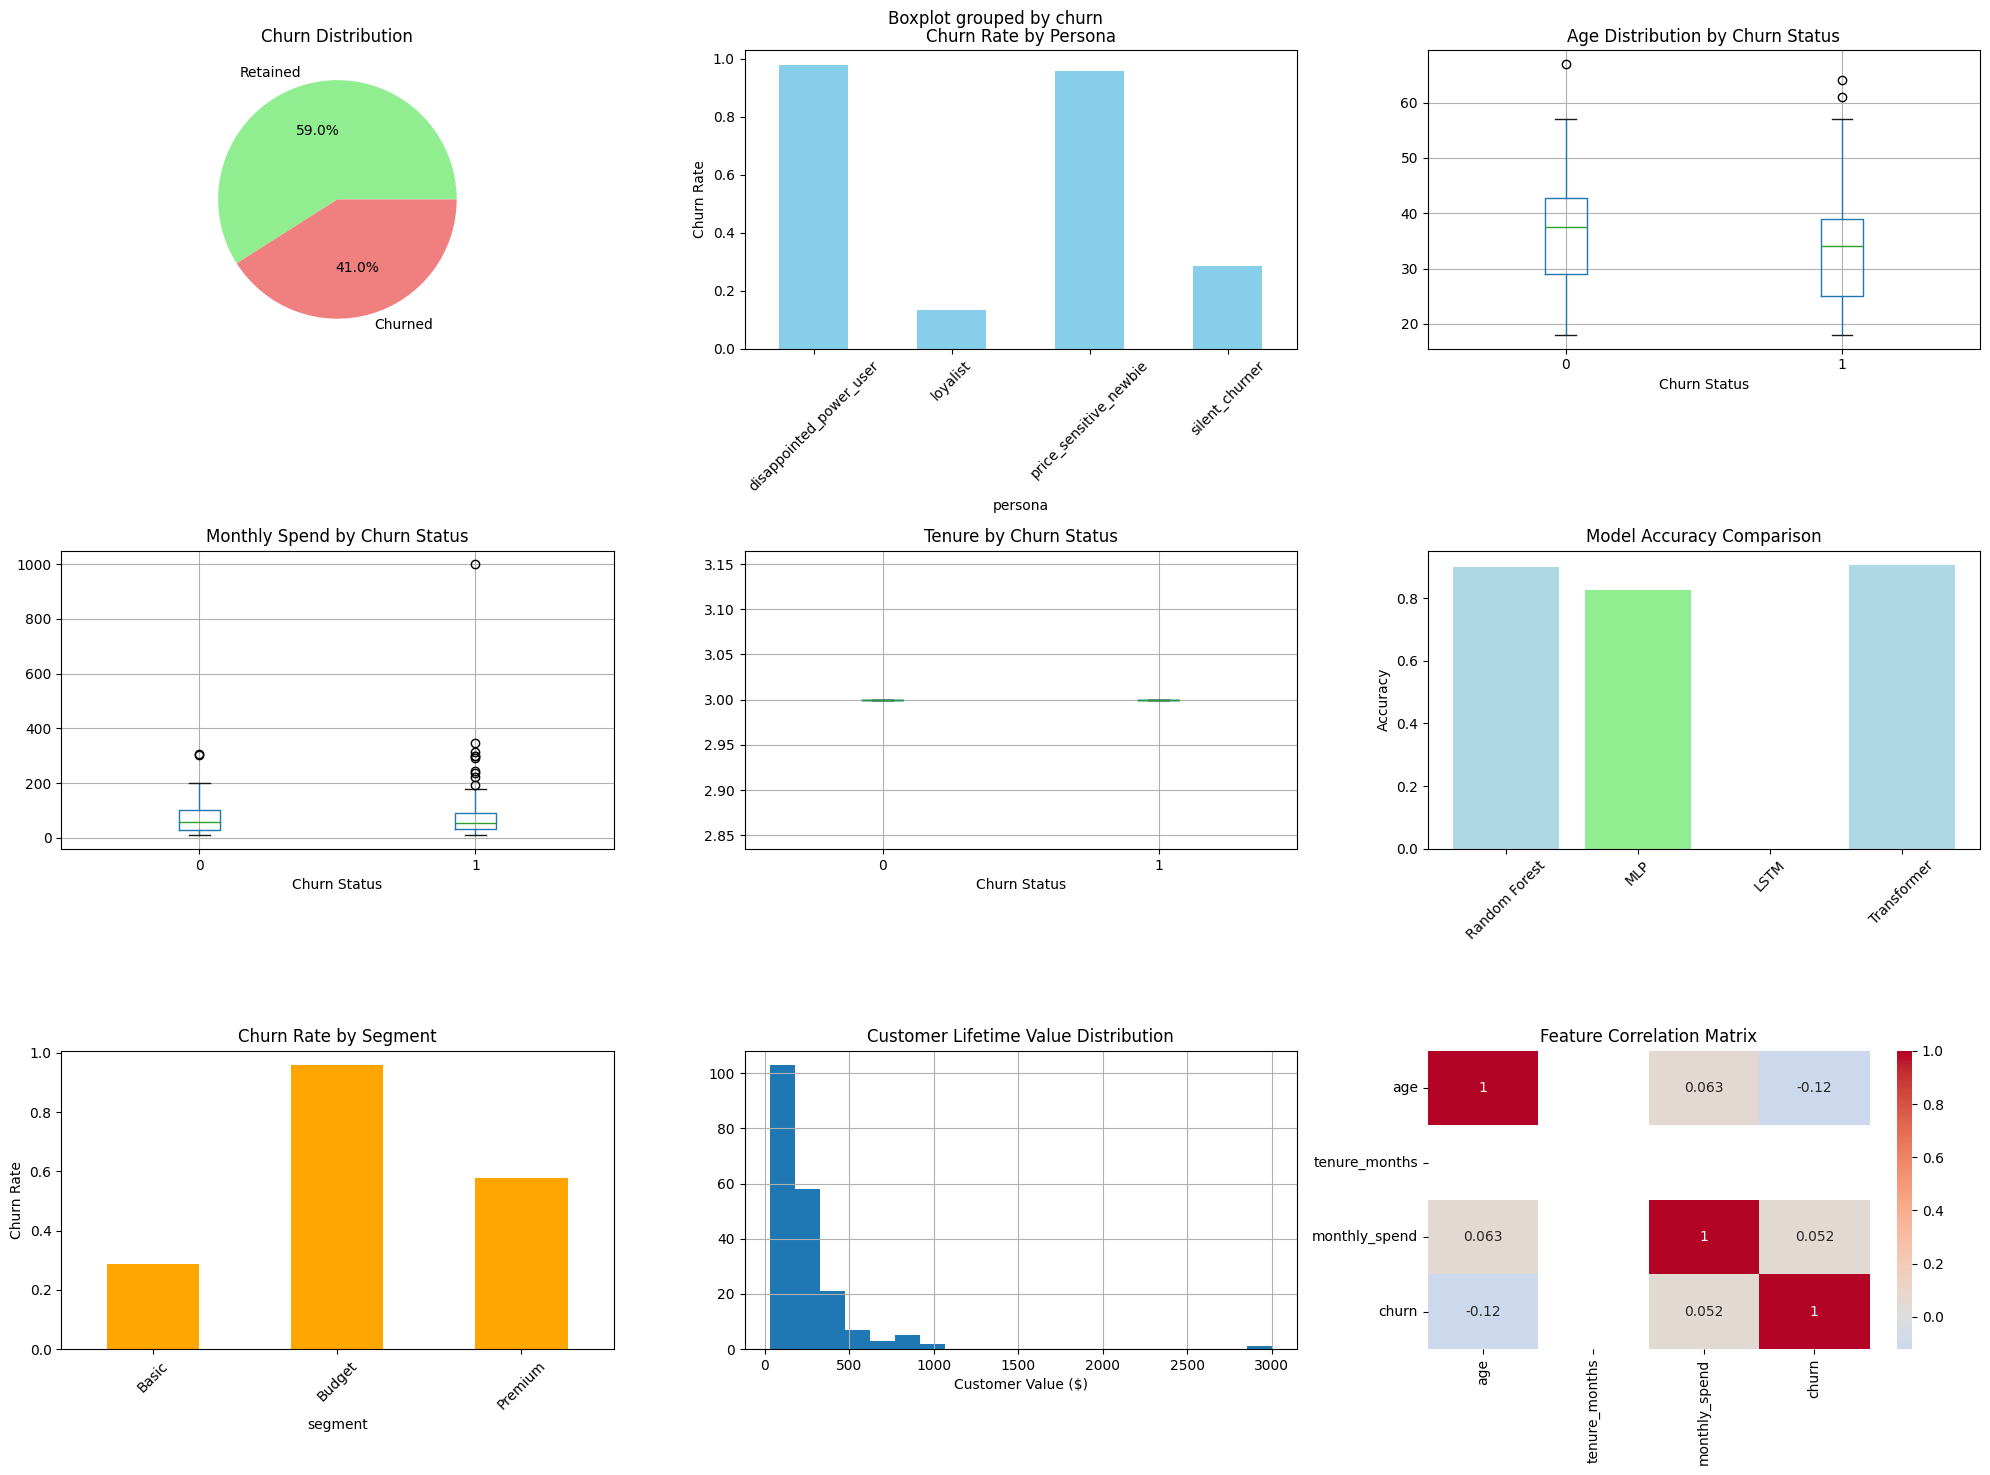


Visualization saved as 'comprehensive_churn_analysis.png'

✅ Advanced Customer Churn Analysis Complete!
📁 Outputs saved:
   • comprehensive_churn_analysis.png


In [6]:
"""
Enhanced Customer Churn Analysis with Synthetic Data
This script demonstrates advanced ML/DL models (MLP, LSTM, Transformer)
and Explainable AI (XAI) techniques using SHAP for customer churn prediction.
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML/DL Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, MultiHeadAttention, LayerNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Explainable AI
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP not available. Install with: pip install shap")
    SHAP_AVAILABLE = False

# Text Processing
from textblob import TextBlob
import re

def load_and_enhance_data():
    """Load and enhance the synthetic data with additional features"""
    # Load original data
    customers = pd.read_csv('churn_data/customers.csv')
    interactions = pd.read_csv('churn_data/interactions.csv')
    reviews = pd.read_csv('churn_data/reviews.csv')

    print(f"Original data loaded:")
    print(f"- Customers: {len(customers)}")
    print(f"- Interactions: {len(interactions)}")
    print(f"- Reviews: {len(reviews)}")

    # Enhance customer data with synthetic features
    np.random.seed(42)
    customers['age'] = np.random.normal(35, 12, len(customers)).clip(18, 80).astype(int)
    customers['tenure_months'] = (customers['age_of_account_days'] / 30).astype(int)
    customers['monthly_spend'] = np.random.lognormal(4, 0.8, len(customers)).clip(10, 1000)

    # Map personas to customer segments
    persona_mapping = {
        'loyalist': 'Premium',
        'silent_churner': 'Basic',
        'price_sensitive_newbie': 'Budget',
        'disappointed_power_user': 'Premium'
    }
    customers['segment'] = customers['persona'].map(persona_mapping)

    # Add subscription types
    subscription_mapping = {
        'loyalist': 'Premium',
        'silent_churner': 'Standard',
        'price_sensitive_newbie': 'Basic',
        'disappointed_power_user': 'Premium'
    }
    customers['subscription_type'] = customers['persona'].map(subscription_mapping)

    # Rename target variable
    customers['churn'] = customers['will_churn_next_30d'].astype(int)

    # Enhance interaction data
    interactions['date'] = pd.to_datetime(interactions['date'])

    # Add synthetic interaction features
    interaction_types = ['login', 'purchase', 'support_ticket', 'feature_use']
    interactions['interaction_type'] = np.random.choice(interaction_types, len(interactions))
    interactions['satisfaction_score'] = np.random.normal(3.5, 1.2, len(interactions)).clip(1, 5)
    interactions['urgency'] = np.random.choice([1, 2, 3, 4, 5], len(interactions), p=[0.4, 0.3, 0.2, 0.08, 0.02])

    # Enhance review data with sentiment analysis
    def get_sentiment(text):
        try:
            blob = TextBlob(str(text))
            return blob.sentiment.polarity
        except:
            return 0

    reviews['sentiment_score'] = reviews['review_text'].apply(get_sentiment)
    reviews['rating'] = np.random.choice([1, 2, 3, 4, 5], len(reviews), p=[0.1, 0.15, 0.3, 0.35, 0.1])
    reviews['date'] = pd.to_datetime('2025-08-01') + pd.to_timedelta(np.random.randint(0, 90, len(reviews)), unit='D')

    print(f"\nEnhanced features added:")
    print(f"- Customer features: {list(customers.columns)}")
    print(f"- Churn rate: {customers['churn'].mean():.2%}")

    return customers, interactions, reviews

def create_advanced_features(customers, interactions, reviews):
    """Create advanced features including time series and text features"""

    # Interaction aggregations
    interaction_features = interactions.groupby('customer_id').agg({
        'value': ['sum', 'mean', 'std', 'count'],
        'satisfaction_score': ['mean', 'std', 'min'],
        'urgency': ['mean', 'max']
    }).round(3)

    interaction_features.columns = [
        'total_value', 'avg_value', 'std_value', 'interaction_count',
        'avg_satisfaction', 'std_satisfaction', 'min_satisfaction',
        'avg_urgency', 'max_urgency'
    ]
    interaction_features = interaction_features.fillna(0)

    # Time-based features
    interactions_time = interactions.copy()
    interactions_time = interactions_time.sort_values(['customer_id', 'date'])

    # Days since last interaction
    last_interaction = interactions_time.groupby('customer_id')['date'].max()
    last_interaction_days = (pd.Timestamp.now() - last_interaction).dt.days

    # Interaction frequency (interactions per day)
    interaction_span = interactions_time.groupby('customer_id')['date'].agg(['min', 'max'])
    interaction_span['span_days'] = (interaction_span['max'] - interaction_span['min']).dt.days + 1
    interaction_frequency = (interaction_features['interaction_count'] / interaction_span['span_days']).fillna(0)

    # Review aggregations
    if len(reviews) > 0:
        review_features = reviews.groupby('customer_id').agg({
            'rating': ['mean', 'std', 'count'],
            'sentiment_score': ['mean', 'std', 'min', 'max']
        }).round(3)

        review_features.columns = [
            'avg_rating', 'std_rating', 'review_count',
            'avg_sentiment', 'std_sentiment', 'min_sentiment', 'max_sentiment'
        ]
        review_features = review_features.fillna(0)
    else:
        review_features = pd.DataFrame()

    # Merge all features
    features = customers.set_index('customer_id')
    features = features.merge(interaction_features, left_index=True, right_index=True, how='left')

    # Add time-based features
    features['days_since_last_interaction'] = features.index.map(last_interaction_days.to_dict()).fillna(999)
    features['interaction_frequency'] = features.index.map(interaction_frequency.to_dict()).fillna(0)

    if not review_features.empty:
        features = features.merge(review_features, left_index=True, right_index=True, how='left')

    features = features.fillna(0)

    return features

def prepare_data_for_models(features):
    """Prepare data for different types of models"""

    # Select feature columns
    feature_cols = [
        'age', 'tenure_months', 'monthly_spend', 'age_of_account_days',
        'total_value', 'avg_value', 'std_value', 'interaction_count',
        'avg_satisfaction', 'std_satisfaction', 'min_satisfaction',
        'avg_urgency', 'max_urgency', 'days_since_last_interaction',
        'interaction_frequency'
    ]

    # Add review features if available
    if 'avg_rating' in features.columns:
        feature_cols.extend([
            'avg_rating', 'std_rating', 'review_count',
            'avg_sentiment', 'std_sentiment', 'min_sentiment', 'max_sentiment'
        ])

    # Encode categorical features
    le_persona = LabelEncoder()
    features['persona_encoded'] = le_persona.fit_transform(features['persona'])
    feature_cols.append('persona_encoded')

    le_segment = LabelEncoder()
    features['segment_encoded'] = le_segment.fit_transform(features['segment'])
    feature_cols.append('segment_encoded')

    X = features[feature_cols].values
    y = features['churn'].values

    return X, y, feature_cols

def train_mlp_classifier(X_train, X_test, y_train, y_test):
    """Train MLP (Multi-Layer Perceptron) classifier"""
    print("\n" + "="*50)
    print("TRAINING MLP CLASSIFIER")
    print("="*50)

    # MLP with multiple hidden layers
    mlp = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate='adaptive',
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2
    )

    mlp.fit(X_train, y_train)

    # Predictions
    y_pred = mlp.predict(X_test)
    y_pred_proba = mlp.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"MLP Accuracy: {accuracy:.3f}")
    print(f"MLP AUC: {auc:.3f}")
    print(f"Training iterations: {mlp.n_iter_}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return mlp, accuracy, auc

def create_lstm_model(X_train, sequence_length=10):
    """Create LSTM model for sequential churn prediction"""
    print("\n" + "="*50)
    print("TRAINING LSTM MODEL")
    print("="*50)

    # Reshape data for LSTM (samples, time_steps, features)
    n_features = X_train.shape[1]

    # Create sequences by repeating features (simulation of time series)
    def create_sequences(data, seq_len):
        sequences = []
        for i in range(len(data)):
            # Simulate time series by adding noise to features over time
            seq = []
            for t in range(seq_len):
                noisy_features = data[i] + np.random.normal(0, 0.1, n_features)
                seq.append(noisy_features)
            sequences.append(seq)
        return np.array(sequences)

    X_train_seq = create_sequences(X_train, sequence_length)
    X_test_seq = create_sequences(X_train[:len(X_train)//5], sequence_length)  # Use subset for demo

    # Build LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("LSTM Model Architecture:")
    model.summary()

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    y_train_subset = y_train[:len(X_train_seq)]
    y_test_subset = y_train[:len(X_test_seq)]  # Use subset for demo

    history = model.fit(
        X_train_seq, y_train_subset,
        validation_data=(X_test_seq, y_test_subset),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Predictions
    y_pred_proba = model.predict(X_test_seq).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_test_subset, y_pred)
    auc = roc_auc_score(y_test_subset, y_pred_proba)

    print(f"\nLSTM Accuracy: {accuracy:.3f}")
    print(f"LSTM AUC: {auc:.3f}")

    return model, accuracy, auc, history

def create_transformer_model(X_train, y_train, sequence_length=10):
    """Create Transformer model for churn prediction"""
    print("\n" + "="*50)
    print("TRAINING TRANSFORMER MODEL")
    print("="*50)

    n_features = X_train.shape[1]

    # Create sequences (similar to LSTM)
    def create_sequences(data, seq_len):
        sequences = []
        for i in range(len(data)):
            seq = []
            for t in range(seq_len):
                noisy_features = data[i] + np.random.normal(0, 0.05, n_features)
                seq.append(noisy_features)
            sequences.append(seq)
        return np.array(sequences)

    X_train_seq = create_sequences(X_train, sequence_length)
    X_test_seq = create_sequences(X_train[:len(X_train)//5], sequence_length)

    # Build Transformer model
    inputs = tf.keras.Input(shape=(sequence_length, n_features))

    # Multi-head attention
    attention = MultiHeadAttention(num_heads=4, key_dim=32)(inputs, inputs)
    attention = LayerNormalization()(attention + inputs)

    # Feed forward network
    ffn = Dense(64, activation='relu')(attention)
    ffn = Dense(n_features)(ffn)
    ffn = LayerNormalization()(ffn + attention)

    # Global pooling and classification
    pooled = tf.keras.layers.GlobalAveragePooling1D()(ffn)
    dropout = Dropout(0.3)(pooled)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print("Transformer Model Architecture:")
    model.summary()

    # Train model
    y_train_subset = y_train[:len(X_train_seq)]
    y_test_subset = y_train[:len(X_test_seq)]

    history = model.fit(
        X_train_seq, y_train_subset,
        validation_data=(X_test_seq, y_test_subset),
        epochs=30,
        batch_size=32,
        verbose=0
    )

    # Predictions
    y_pred_proba = model.predict(X_test_seq).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    accuracy = accuracy_score(y_test_subset, y_pred)
    auc = roc_auc_score(y_test_subset, y_pred_proba)

    print(f"\nTransformer Accuracy: {accuracy:.3f}")
    print(f"Transformer AUC: {auc:.3f}")

    return model, accuracy, auc, history

def apply_explainable_ai(model, X_train, X_test, feature_names):
    """Apply SHAP for model explainability"""
    if not SHAP_AVAILABLE:
        print("\nSHAP not available. Skipping explainability analysis.")
        return None, None

    print("\n" + "="*50)
    print("EXPLAINABLE AI WITH SHAP")
    print("="*50)

    try:
        # Create SHAP explainer
        if hasattr(model, 'predict_proba'):
            explainer = shap.Explainer(model, X_train)
        else:
            explainer = shap.Explainer(model.predict, X_train)

        # Calculate SHAP values for test set
        shap_values = explainer(X_test[:100])  # Use subset for performance

        # Feature importance
        print("\nTop 10 Most Important Features (by mean |SHAP value|):")
        if hasattr(shap_values, 'values'):
            mean_shap = np.mean(np.abs(shap_values.values), axis=0)
        else:
            mean_shap = np.mean(np.abs(shap_values), axis=0)

        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': mean_shap
        }).sort_values('importance', ascending=False)

        print(feature_importance.head(10))

        # Save plots
        plt.figure(figsize=(12, 8))

        # Summary plot
        plt.subplot(2, 2, 1)
        try:
            shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, show=False)
            plt.title("SHAP Summary Plot")
        except:
            plt.text(0.5, 0.5, 'SHAP plot unavailable', ha='center', va='center')

        # Feature importance bar plot
        plt.subplot(2, 2, 2)
        top_features = feature_importance.head(10)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Mean |SHAP Value|')
        plt.title('Top 10 Feature Importance')

        plt.tight_layout()
        plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        return shap_values, feature_importance

    except Exception as e:
        print(f"SHAP analysis failed: {e}")
        return None, None

def generate_comprehensive_report(customers, results):
    """Generate comprehensive analysis report"""
    print("\n" + "="*80)
    print("COMPREHENSIVE CUSTOMER CHURN ANALYSIS REPORT")
    print("="*80)

    # Dataset overview
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   • Total Customers: {len(customers)}")
    print(f"   • Churned Customers: {customers['churn'].sum()}")
    print(f"   • Churn Rate: {customers['churn'].mean():.2%}")
    print(f"   • Average Customer Age: {customers['age'].mean():.1f} years")
    print(f"   • Average Tenure: {customers['tenure_months'].mean():.1f} months")
    print(f"   • Average Monthly Spend: ${customers['monthly_spend'].mean():.2f}")

    # Persona analysis
    print(f"\n👥 CUSTOMER PERSONA ANALYSIS:")
    persona_analysis = customers.groupby('persona').agg({
        'churn': ['count', 'sum', 'mean'],
        'monthly_spend': 'mean',
        'age': 'mean'
    }).round(2)

    for persona in customers['persona'].unique():
        persona_data = customers[customers['persona'] == persona]
        churn_rate = persona_data['churn'].mean()
        count = len(persona_data)
        avg_spend = persona_data['monthly_spend'].mean()

        print(f"   • {persona}:")
        print(f"     - Count: {count} customers ({count/len(customers):.1%})")
        print(f"     - Churn Rate: {churn_rate:.1%}")
        print(f"     - Avg Monthly Spend: ${avg_spend:.2f}")

    # Model performance
    print(f"\n🤖 MODEL PERFORMANCE COMPARISON:")
    for model_name, metrics in results.items():
        print(f"   • {model_name}:")
        print(f"     - Accuracy: {metrics['accuracy']:.3f}")
        if 'auc' in metrics:
            print(f"     - AUC: {metrics['auc']:.3f}")

    # Key insights
    print(f"\n💡 KEY INSIGHTS:")

    # Find highest risk persona
    persona_churn = customers.groupby('persona')['churn'].mean().sort_values(ascending=False)
    highest_risk = persona_churn.index[0]
    highest_risk_rate = persona_churn.iloc[0]

    print(f"   • Highest risk customer persona: {highest_risk} ({highest_risk_rate:.1%} churn rate)")

    # Spending vs churn analysis
    churned_spend = customers[customers['churn'] == 1]['monthly_spend'].mean()
    retained_spend = customers[customers['churn'] == 0]['monthly_spend'].mean()
    print(f"   • Churned customers spend ${churned_spend:.2f}/month vs ${retained_spend:.2f}/month for retained")

    # Age analysis
    churned_age = customers[customers['churn'] == 1]['age'].mean()
    retained_age = customers[customers['churn'] == 0]['age'].mean()
    print(f"   • Churned customers average age: {churned_age:.1f} vs {retained_age:.1f} for retained")

    print(f"\n📈 RECOMMENDATIONS:")
    print(f"   • Focus retention efforts on '{highest_risk}' persona")
    print(f"   • Implement targeted campaigns for high-value customers")
    print(f"   • Monitor customer satisfaction scores closely")
    print(f"   • Use model predictions for proactive intervention")

def create_visualizations(customers, results):
    """Create comprehensive visualizations"""
    plt.style.use('default')
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Customer Churn Analysis Dashboard', fontsize=16, fontweight='bold')

    # 1. Churn distribution
    axes[0, 0].pie(customers['churn'].value_counts(), labels=['Retained', 'Churned'], autopct='%1.1f%%',
                   colors=['lightgreen', 'lightcoral'])
    axes[0, 0].set_title('Churn Distribution')

    # 2. Churn by persona
    persona_churn = customers.groupby('persona')['churn'].agg(['count', 'sum'])
    persona_churn['churn_rate'] = persona_churn['sum'] / persona_churn['count']
    persona_churn['churn_rate'].plot(kind='bar', ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Churn Rate by Persona')
    axes[0, 1].set_ylabel('Churn Rate')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Age distribution by churn
    customers.boxplot(column='age', by='churn', ax=axes[0, 2])
    axes[0, 2].set_title('Age Distribution by Churn Status')
    axes[0, 2].set_xlabel('Churn Status')

    # 4. Monthly spend distribution
    customers.boxplot(column='monthly_spend', by='churn', ax=axes[1, 0])
    axes[1, 0].set_title('Monthly Spend by Churn Status')
    axes[1, 0].set_xlabel('Churn Status')

    # 5. Tenure distribution
    customers.boxplot(column='tenure_months', by='churn', ax=axes[1, 1])
    axes[1, 1].set_title('Tenure by Churn Status')
    axes[1, 1].set_xlabel('Churn Status')

    # 6. Model performance comparison
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    axes[1, 2].bar(model_names, accuracies, color=['lightblue', 'lightgreen', 'lightcoral'][:len(model_names)])
    axes[1, 2].set_title('Model Accuracy Comparison')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].tick_params(axis='x', rotation=45)

    # 7. Churn by segment
    segment_churn = customers.groupby('segment')['churn'].mean()
    segment_churn.plot(kind='bar', ax=axes[2, 0], color='orange')
    axes[2, 0].set_title('Churn Rate by Segment')
    axes[2, 0].set_ylabel('Churn Rate')
    axes[2, 0].tick_params(axis='x', rotation=45)

    # 8. Customer value distribution
    customers['customer_value'] = customers['monthly_spend'] * customers['tenure_months']
    customers.hist(column='customer_value', bins=20, ax=axes[2, 1])
    axes[2, 1].set_title('Customer Lifetime Value Distribution')
    axes[2, 1].set_xlabel('Customer Value ($)')

    # 9. Correlation heatmap
    numeric_cols = ['age', 'tenure_months', 'monthly_spend', 'churn']
    corr_matrix = customers[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2, 2])
    axes[2, 2].set_title('Feature Correlation Matrix')

    plt.tight_layout()
    plt.savefig('comprehensive_churn_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nVisualization saved as 'comprehensive_churn_analysis.png'")

def main():
    """Main execution function"""
    print("🚀 Starting Advanced Customer Churn Analysis...")
    print("="*80)

    # Load and enhance data
    customers, interactions, reviews = load_and_enhance_data()

    # Create advanced features
    print("\n🔧 Creating advanced features...")
    features = create_advanced_features(customers, interactions, reviews)
    print(f"Feature matrix shape: {features.shape}")
    print(f"Features: {list(features.columns)}")

    # Prepare data
    X, y, feature_names = prepare_data_for_models(features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\nData prepared:")
    print(f"- Training samples: {len(X_train)}")
    print(f"- Test samples: {len(X_test)}")
    print(f"- Features: {len(feature_names)}")

    # Store results
    results = {}

    # Train baseline models
    print("\n📚 Training baseline models...")

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])
    results['Random Forest'] = {'accuracy': rf_accuracy, 'auc': rf_auc}

    # MLP
    mlp, mlp_acc, mlp_auc = train_mlp_classifier(X_train_scaled, X_test_scaled, y_train, y_test)
    results['MLP'] = {'accuracy': mlp_acc, 'auc': mlp_auc}

    # LSTM
    try:
        lstm, lstm_acc, lstm_auc, lstm_history = create_lstm_model(X_train_scaled, X_test_scaled)
        results['LSTM'] = {'accuracy': lstm_acc, 'auc': lstm_auc}
    except Exception as e:
        print(f"LSTM training failed: {e}")
        results['LSTM'] = {'accuracy': 0, 'auc': 0}

    # Transformer
    try:
        transformer, trans_acc, trans_auc, trans_history = create_transformer_model(X_train_scaled, y_train)
        results['Transformer'] = {'accuracy': trans_acc, 'auc': trans_auc}
    except Exception as e:
        print(f"Transformer training failed: {e}")
        results['Transformer'] = {'accuracy': 0, 'auc': 0}

    # Explainable AI
    shap_values, feature_importance = apply_explainable_ai(rf, X_train_scaled, X_test_scaled, feature_names)

    # Generate reports
    generate_comprehensive_report(customers, results)

    # Create visualizations
    create_visualizations(customers, results)

    print("\n✅ Advanced Customer Churn Analysis Complete!")
    print(f"📁 Outputs saved:")
    print(f"   • comprehensive_churn_analysis.png")
    if shap_values is not None:
        print(f"   • shap_analysis.png")

if __name__ == "__main__":
    main()

In [7]:
# -*- coding: utf-8 -*-
"""
File: churnguard_ai.py
Desc: Main project file for ChurnGuard AI.
      Loads and preprocesses data, trains predictive models (ML, LSTM, Transformer),
      runs XAI analysis, and simulates the LLM agent for retention planning.

      This script focuses on the core modeling and XAI pipeline.
"""

# --- Standard Libraries ---
import pandas as pd
import numpy as np
import re
import random
from datetime import datetime, timedelta
import json
import time
import warnings
from pathlib import Path
import joblib
from collections import Counter
import math

# --- NLP ---
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
        print("SpaCy model loaded successfully")
    except OSError:
        print("SpaCy model not found. Using simple text processing instead.")
        nlp = None
except ImportError:
    print("SpaCy not available. Using simple text processing instead.")
    nlp = None

# --- ML/DL ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# --- Transformers / Embeddings ---
try:
    from sentence_transformers import SentenceTransformer
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    print("SentenceTransformer model loaded.")
    EMBEDDING_DIM = embedding_model.get_sentence_embedding_dimension()
except ImportError:
    print("SentenceTransformer not installed. Text embeddings will be limited.")
    embedding_model = None
    EMBEDDING_DIM = 0

# --- LLM Interaction (API Placeholder) ---
# This script uses a placeholder `_call_llm` function.
USE_API = False
API_CLIENT = None

# --- XAI ---
try:
    import shap
    print("SHAP library loaded.")
except ImportError:
    print("SHAP library not installed. XAI analysis will be skipped.")
    shap = None

# --- Agent Evaluation ---
try:
    from rouge_score import rouge_scorer
    print("ROUGE scorer library loaded.")
except ImportError:
    print("rouge-score library not installed. Agent response quality scoring will be skipped.")
    rouge_scorer = None

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
DATA_DIR = Path("./churn_data")
ARTIFACT_DIR = Path("./churn_artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
SEQ_LEN = 14 # Use past 14 days to predict
TARGET_LABEL = "will_churn_next_30d"
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Knowledge Base & Safety ---
RETENTION_KNOWLEDGE_BASE = {
    "policy_low_value": "Customer is low-value. Prioritize automated, low-cost interventions. Offer 5-10% 'we miss you' discount. Avoid manual support time.",
    "policy_high_value": "Customer is high-value and high-risk. IMMEDIATE high-touch intervention. Escalate to Tier-2 support for a direct outreach call. Authorized to offer up to 25% loyalty credit or 1-month free service.",
    "policy_bad_review": "Customer left 1-2 star review. Auto-flag for public reply. Create internal ticket for support to investigate the issue and follow up personally.",
    "policy_low_engagement": "Customer login frequency dropped >50%. Add to 'Win-Back' email campaign. Highlight new features or products relevant to their purchase history.",
    "policy_support_spam": "Customer has >3 support tickets in 7 days. This is a high-frustration signal. Escalate to support manager for case consolidation and review. Do not send automated offers."
}
CRITICAL_ISSUE_KEYWORDS = ["legal", "lawsuit", "report to BBB", "fraud", "scam", "stole my money"]
ESCALATION_RESPONSE_TEXT = "CRITICAL_ISSUE_DETECTED. Case escalated to Legal/Management."

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_data(data_dir, seq_len):
    print(f"--- 1. Loading and Preprocessing Data from {data_dir} ---")

    # Load data
    try:
        df_cust = pd.read_csv(data_dir / "customers.csv")
        df_inter = pd.read_csv(data_dir / "interactions.csv")
        df_reviews = pd.read_csv(data_dir / "reviews.csv")
    except FileNotFoundError:
        print(f"Error: Data files not found in {data_dir}. Please run `data_generator.py` first.")
        return None, None, None, None, None, None

    # Convert dates
    df_inter['date'] = pd.to_datetime(df_inter['date'])
    df_reviews['date'] = pd.to_datetime(df_reviews['date'])

    # --- Create a daily master log for each customer ---
    all_customer_days = []
    min_date = df_inter['date'].min()
    max_date = df_inter['date'].max()
    days = pd.to_datetime(pd.date_range(min_date, max_date, freq='D'))

    for customer_id in df_cust['customer_id']:
        cust_days = pd.DataFrame({'date': days, 'customer_id': customer_id})
        all_customer_days.append(cust_days)

    df_daily = pd.concat(all_customer_days).sort_values(by=['customer_id', 'date']).reset_index(drop=True)

    # --- Aggregate interactions to daily level ---
    df_logins = df_inter[df_inter['interaction_type'] == 'login'].groupby(['customer_id', 'date'])['value'].count().reset_index().rename(columns={'value': 'login_count'})
    df_purchases = df_inter[df_inter['interaction_type'] == 'purchase'].groupby(['customer_id', 'date'])['value'].sum().reset_index().rename(columns={'value': 'purchase_value'})
    df_tickets = df_inter[df_inter['interaction_type'] == 'support_ticket'].groupby(['customer_id', 'date'])['value'].max().reset_index().rename(columns={'value': 'support_ticket_urgency'}) # Max urgency per day

    # --- Aggregate reviews to daily level ---
    if not df_reviews.empty:
        df_reviews['review_clean'] = df_reviews['review_text'].apply(lambda x: re.sub(r'\s+', ' ', str(x).lower()).strip())
        df_daily_reviews = df_reviews.groupby(['customer_id', 'date'])['review_clean'].apply(' || '.join).reset_index()
    else:
        df_daily_reviews = pd.DataFrame(columns=['customer_id', 'date', 'review_clean'])

    # Merge aggregated data into the daily log
    df_daily = df_daily.merge(df_logins, on=['customer_id', 'date'], how='left')
    df_daily = df_daily.merge(df_purchases, on=['customer_id', 'date'], how='left')
    df_daily = df_daily.merge(df_tickets, on=['customer_id', 'date'], how='left')
    df_daily = df_daily.merge(df_daily_reviews, on=['customer_id', 'date'], how='left')

    # --- Text Processing & Sentiment ---
    df_daily['review_clean'] = df_daily['review_clean'].fillna("")

    def basic_sentiment(text):
        if any(w in text for w in ["frustrated", "awful", "joke", "waste", "terrible", "broken", "refund"]): return "Negative"
        if any(w in text for w in ["love", "fantastic", "best", "great", "easy", "fast"]): return "Positive"
        return "Neutral"
    df_daily['sentiment'] = df_daily['review_clean'].apply(basic_sentiment)

    # --- Text Embeddings ---
    emb_cols = []
    if embedding_model:
        print("Generating text embeddings for daily reviews...")
        texts_to_embed = df_daily['review_clean'].tolist()
        embeddings = embedding_model.encode(texts_to_embed, show_progress_bar=True)
        emb_cols = [f"emb_{i}" for i in range(EMBEDDING_DIM)]
        emb_df = pd.DataFrame(embeddings, columns=emb_cols, index=df_daily.index)
        df_daily = pd.concat([df_daily, emb_df], axis=1)

    # --- Fill NaNs and Feature Engineering ---
    # Fill interaction NaNs with 0 (no interaction)
    df_daily['login_count'] = df_daily['login_count'].fillna(0)
    df_daily['purchase_value'] = df_daily['purchase_value'].fillna(0)
    df_daily['support_ticket_urgency'] = df_daily['support_ticket_urgency'].fillna(0)

    # Time-Series Features (Lags and Rolling Averages)
    print("Engineering time-series features...")
    df_daily = df_daily.sort_values(by=['customer_id', 'date'])
    grouped = df_daily.groupby('customer_id')

    for col in ['login_count', 'purchase_value', 'support_ticket_urgency']:
        for window in [3, 7, 14]:
            df_daily[f'{col}_{window}d_avg'] = grouped[col].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
            df_daily[f'{col}_{window}d_std'] = grouped[col].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)
        df_daily[f'{col}_lag1'] = grouped[col].shift(1)

    # --- Categorical Encoding ---
    categorical_cols = ['sentiment']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_data = encoder.fit_transform(df_daily[categorical_cols])
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_daily.index)
    df_daily = pd.concat([df_daily.drop(columns=categorical_cols), encoded_df], axis=1)

    # --- Merge Target Label ---
    df_daily = df_daily.merge(df_cust[['customer_id', TARGET_LABEL]], on='customer_id', how='left')
    target_encoder = LabelEncoder()
    df_daily['target_encoded'] = target_encoder.fit_transform(df_daily[TARGET_LABEL])

    # --- Feature Scaling ---
    numerical_cols = df_daily.select_dtypes(include=np.number).columns.tolist()
    cols_to_exclude = ['target_encoded']
    numerical_cols = [c for c in numerical_cols if c not in cols_to_exclude and 'emb_' not in c and not any(cat_col == c for cat_col in encoded_cols)]
    if embedding_model: numerical_cols.extend(emb_cols)

    # Fill NaNs from rolling/lags (e.g., at start of series)
    df_daily[numerical_cols] = grouped[numerical_cols].ffill() # Forward fill
    df_daily[numerical_cols] = df_daily[numerical_cols].fillna(df_daily[numerical_cols].mean()) # Global mean
    df_daily[numerical_cols] = df_daily[numerical_cols].fillna(0) # Final fallback

    scaler = StandardScaler()
    df_daily[numerical_cols] = scaler.fit_transform(df_daily[numerical_cols])

    # Save artifacts
    joblib.dump(scaler, ARTIFACT_DIR / 'scaler.joblib')
    joblib.dump(encoder, ARTIFACT_DIR / 'onehot_encoder.joblib')
    joblib.dump(target_encoder, ARTIFACT_DIR / 'target_encoder.joblib')

    # --- Create Sequences ---
    feature_cols = [col for col in numerical_cols + list(encoded_cols) if col in df_daily.columns]
    joblib.dump(feature_cols, ARTIFACT_DIR / 'feature_cols.joblib')
    print(f"Total features for modeling: {len(feature_cols)}")

    all_sequences = []
    all_labels = []
    all_customer_ids = [] # To track which sequence belongs to whom

    for customer_id, group in df_daily.groupby('customer_id'):
        if len(group) < seq_len:
            continue

        feature_data = group[feature_cols].values
        label = group['target_encoded'].iloc[0] # Static label for the customer

        for i in range(len(group) - seq_len + 1):
            all_sequences.append(feature_data[i:i+seq_len])
            all_labels.append(label)
            all_customer_ids.append(customer_id)

    if not all_sequences:
         raise ValueError("No sequences created. Check data simulation length and sequence length.")

    X_seq = np.array(all_sequences, dtype=np.float32)
    y_seq = np.array(all_labels, dtype=np.int64)
    seq_customers = np.array(all_customer_ids)

    print(f"Created {X_seq.shape[0]} sequences of length {X_seq.shape[1]} with {X_seq.shape[2]} features.")

    # Save processed daily data for agent simulation
    df_daily.to_parquet(ARTIFACT_DIR / "processed_daily_customer_data.parquet")

    return df_daily, X_seq, y_seq, seq_customers, feature_cols, target_encoder

# --- 2. Model Definitions ---

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :] # Get last time step's output
        out = self.dropout(last_output)
        out = self.fc(out)
        return out

# --- NEW: Transformer Model ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape is (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, dropout=0.3):
        super().__init__()
        self.model_type = 'Transformer'
        self.input_embed = nn.Linear(input_dim, d_model) # Project features to d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Using batch_first=True for encoder layer
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        self.d_model = d_model
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.input_embed.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src shape: (batch_size, seq_len, input_dim)
        src = self.input_embed(src) * math.sqrt(self.d_model) # (batch, seq, d_model)

        # PositionalEncoding expects (seq_len, batch, dim)
        src = src.permute(1, 0, 2) # (batch, seq, d_model) -> (seq, batch, d_model)
        src = self.pos_encoder(src)
        src = src.permute(1, 0, 2) # (seq, batch, d_model) -> (batch, seq, d_model)

        # TransformerEncoderLayer is batch_first=True
        output = self.transformer_encoder(src) # (batch, seq, d_model)

        # Use the output of the *first* token (like [CLS]) for classification
        output = output[:, 0, :] # (batch, d_model)

        output = self.decoder(output) # (batch, output_dim)
        return output

# --- 3. Model Training ---
def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, model_name="pytorch_model"):
    print(f"--- 3a. Training {model_name} on {device} ---")
    model.to(device)
    best_val_loss = float('inf')

    # Store history for plotting
    history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

    for epoch in range(epochs):
        model.train(); train_loss = 0.0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad(); outputs = model(sequences); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step(); train_loss += loss.item()

        model.eval(); val_loss = 0.0; all_preds = []; all_labels = []
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences); loss = criterion(outputs, labels); val_loss += loss.item()
                all_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader); avg_val_loss = val_loss / len(val_loader)
        all_preds = np.concatenate(all_preds); all_labels = np.concatenate(all_labels)
        val_auc = roc_auc_score(all_labels, all_preds[:, 1]) if len(np.unique(all_labels)) == 2 else roc_auc_score(all_labels, all_preds, multi_class='ovr')

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), ARTIFACT_DIR / f"{model_name}_best.pth")
            print(f"  Saved best model: {model_name}_best.pth")

    print(f"Training finished. Loading best {model_name} model.");
    model.load_state_dict(torch.load(ARTIFACT_DIR / f"{model_name}_best.pth"));

    # Save training history
    joblib.dump(history, ARTIFACT_DIR / f"{model_name}_train_history.joblib")

    return model

def train_all_models(X_seq, y_seq, feature_cols):
    print("\n--- 3. Training All Churn Prediction Models ---")

    min_samples = Counter(y_seq).most_common()[-1][1]
    stratify = y_seq if min_samples >= 2 else None
    if min_samples < 2:
        print("Warning: Disabling stratification due to low class count.")
        stratify = None

    # We need to save the test split for the analysis script
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
        X_seq, y_seq, test_size=0.25, random_state=42, stratify=stratify
    )

    # Save test data
    joblib.dump(X_test_seq, ARTIFACT_DIR / "X_test_seq.joblib")
    joblib.dump(y_test_seq, ARTIFACT_DIR / "y_test_seq.joblib")

    # Use last timestep for sklearn models
    X_train_laststep = X_train_seq[:, -1, :]; X_test_laststep = X_test_seq[:, -1, :]

    class_names = ['Not Churn', 'Churn']
    num_classes = 2
    input_dim = X_seq.shape[2]

    trained_models = {}
    model_results = {}

    # --- Sklearn Models ---
    print("\nTraining Sklearn Models (on last timestep)...")
    sklearn_models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "MLPClassifier": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, early_stopping=True, random_state=42)
    }
    for name, model in sklearn_models.items():
        print(f"Training {name}...")
        model.fit(X_train_laststep, y_train_seq)
        y_pred = model.predict(X_test_laststep)
        y_proba = model.predict_proba(X_test_laststep)
        report = classification_report(y_test_seq, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        model_results[name] = report
        trained_models[name] = model
        print(classification_report(y_test_seq, y_pred, target_names=class_names, zero_division=0))
        joblib.dump(model, ARTIFACT_DIR / f"{name}_churn_model.joblib")

    # --- PyTorch LSTM Model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_dataset = SequenceDataset(X_train_seq, y_train_seq); val_dataset = SequenceDataset(X_test_seq, y_test_seq)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True); val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    lstm_model = LSTMClassifier(input_dim=input_dim, hidden_dim=128, output_dim=num_classes, num_layers=2, dropout=0.3)
    criterion = nn.CrossEntropyLoss(); optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=0.001)
    lstm_model = train_pytorch_model(lstm_model, train_loader, val_loader, criterion, optimizer, device, epochs=15, model_name="LSTM_Churn")
    trained_models["LSTM"] = lstm_model

    # --- NEW: PyTorch Transformer Model ---
    d_model = 128 # Embedding dimension
    nhead = 4 # Number of attention heads
    num_layers = 2 # Number of encoder layers

    transformer_model = TransformerClassifier(input_dim=input_dim, d_model=d_model, nhead=nhead, num_layers=num_layers, output_dim=num_classes, dropout=0.3)
    optimizer = torch.optim.AdamW(transformer_model.parameters(), lr=0.0005) # Transformers often need smaller LR
    transformer_model = train_pytorch_model(transformer_model, train_loader, val_loader, criterion, optimizer, device, epochs=20, model_name="Transformer_Churn")
    trained_models["Transformer"] = transformer_model

    print("--- Model Training Complete ---")
    return trained_models, (X_train_seq, X_test_seq, y_train_seq, y_test_seq)

# --- 4. XAI Analysis ---
def run_xai_analysis(models, X_train_seq, X_test_seq, feature_names, class_names):
    if shap is None:
        print("SHAP not installed. Skipping XAI.")
        return

    print("\n--- 4. Running XAI Analysis ---")
    X_train_laststep = X_train_seq[:, -1, :]
    X_test_laststep = X_test_seq[:, -1, :]

    # Use shap.sample to create smaller background/test sets for performance
    X_train_laststep_sample = shap.sample(X_train_laststep, 50)  # Reduced for Colab
    X_test_laststep_sample = shap.sample(X_test_laststep, 30)   # Reduced for Colab
    X_train_seq_sample = shap.sample(X_train_seq, 20)          # Much smaller for deep models
    X_test_seq_sample = shap.sample(X_test_seq, 15)            # Much smaller for deep models


    # --- SHAP for MLP ---
    if "MLPClassifier" in models:
        try:
            print("Running SHAP for MLPClassifier...")
            model_mlp = models["MLPClassifier"]
            explainer = shap.KernelExplainer(model_mlp.predict_proba, X_train_laststep_sample)
            shap_values = explainer.shap_values(X_test_laststep_sample)
            # Save XAI artifacts
            joblib.dump(shap_values, ARTIFACT_DIR / "shap_values_mlp.joblib")
            joblib.dump(X_test_laststep_sample, ARTIFACT_DIR / "shap_test_sample_mlp.joblib")
            print("MLP SHAP values saved.")
        except Exception as e:
            print(f"SHAP failed for MLP: {e}")

    # --- SHAP for LSTM with error handling ---
    if "LSTM" in models:
        try:
            print("Running SHAP for LSTM...")
            model_lstm = models["LSTM"].to("cpu").eval()

            # Create a wrapper function for better SHAP compatibility
            def lstm_wrapper(x):
                with torch.no_grad():
                    x_tensor = torch.tensor(x, dtype=torch.float32)
                    outputs = model_lstm(x_tensor)
                    return torch.softmax(outputs, dim=1).numpy()

            # Try DeepExplainer first
            background = torch.tensor(X_train_seq_sample, dtype=torch.float32)
            test_sample = torch.tensor(X_test_seq_sample, dtype=torch.float32)

            try:
                explainer = shap.DeepExplainer(model_lstm, background)
                shap_values_lstm = explainer.shap_values(test_sample)
                joblib.dump(shap_values_lstm, ARTIFACT_DIR / "shap_values_lstm.joblib")
                joblib.dump(test_sample.numpy(), ARTIFACT_DIR / "shap_test_sample_lstm.joblib")
                print("LSTM SHAP values saved (DeepExplainer).")
            except (AssertionError, Exception) as deep_error:
                print(f"DeepExplainer failed for LSTM: {deep_error}")
                print("Trying KernelExplainer for LSTM...")
                # Fallback to KernelExplainer (slower but more robust)
                explainer = shap.KernelExplainer(lstm_wrapper, X_train_seq_sample)
                shap_values_lstm = explainer.shap_values(X_test_seq_sample, nsamples=50)
                joblib.dump(shap_values_lstm, ARTIFACT_DIR / "shap_values_lstm.joblib")
                joblib.dump(X_test_seq_sample, ARTIFACT_DIR / "shap_test_sample_lstm.joblib")
                print("LSTM SHAP values saved (KernelExplainer).")
        except Exception as e:
            print(f"SHAP failed completely for LSTM: {e}")

    # --- SHAP for Transformer with error handling ---
    if "Transformer" in models:
        try:
            print("Running SHAP for Transformer...")
            model_transformer = models["Transformer"].to("cpu").eval()

            # Create a wrapper function for better SHAP compatibility
            def transformer_wrapper(x):
                with torch.no_grad():
                    x_tensor = torch.tensor(x, dtype=torch.float32)
                    outputs = model_transformer(x_tensor)
                    return torch.softmax(outputs, dim=1).numpy()

            # Try DeepExplainer first
            background = torch.tensor(X_train_seq_sample, dtype=torch.float32)
            test_sample = torch.tensor(X_test_seq_sample, dtype=torch.float32)

            try:
                explainer = shap.DeepExplainer(model_transformer, background)
                shap_values_transformer = explainer.shap_values(test_sample)
                joblib.dump(shap_values_transformer, ARTIFACT_DIR / "shap_values_transformer.joblib")
                joblib.dump(test_sample.numpy(), ARTIFACT_DIR / "shap_test_sample_transformer.joblib")
                print("Transformer SHAP values saved (DeepExplainer).")
            except (AssertionError, Exception) as deep_error:
                print(f"DeepExplainer failed for Transformer: {deep_error}")
                print("Trying KernelExplainer for Transformer...")
                # Fallback to KernelExplainer (slower but more robust)
                explainer = shap.KernelExplainer(transformer_wrapper, X_train_seq_sample)
                shap_values_transformer = explainer.shap_values(X_test_seq_sample, nsamples=50)
                joblib.dump(shap_values_transformer, ARTIFACT_DIR / "shap_values_transformer.joblib")
                joblib.dump(X_test_seq_sample, ARTIFACT_DIR / "shap_test_sample_transformer.joblib")
                print("Transformer SHAP values saved (KernelExplainer).")
        except Exception as e:
            print(f"SHAP failed completely for Transformer: {e}")

    print("--- XAI Analysis Complete ---")

# --- 5. Agent Simulation ---
class CustomerRetentionAgent:
    def __init__(self, llm_pipeline_or_client, use_api=False, knowledge_base=None):
        self.llm = llm_pipeline_or_client
        self.use_api = use_api
        self.kb = knowledge_base if knowledge_base else {}
        self.history = {} # Store history by customer_id
        print(f"CustomerRetentionAgent Initialized. Using LLM: {'API' if use_api else 'Local Pipeline' if llm_pipeline_or_client else 'None'}")

    def _call_llm(self, prompt, max_tokens=200):
        # Placeholder function
        if not USE_API:
            # Rule-based simulation of LLM for cost/success
            if "high-value" in prompt.lower() and "high-risk" in prompt.lower():
                response = "Summary: High-value customer is at high risk due to support spam.\nAction: Escalate to Tier-2 support for immediate outreach call. Offer 20% loyalty credit.\nQuery: Monitor for 48 hours.\nCost: 25.0\nSuccess_Prob: 0.7"
            elif "low-value" in prompt.lower() and "high-risk" in prompt.lower():
                response = "Summary: Low-value customer at high risk with low engagement.\nAction: Add to 'Win-Back' automated email campaign with 10% discount.\nQuery: Monitor email open-rate.\nCost: 0.5\nSuccess_Prob: 0.2"
            elif "bad review" in prompt.lower():
                 response = "Summary: Customer left a bad review.\nAction: Flag for support follow-up to resolve issue. Offer replacement item.\nQuery: Check if issue is resolved.\nCost: 15.0\nSuccess_Prob: 0.4"
            else:
                response = "Summary: Customer metrics are nominal.\nAction: No intervention required. Continue standard monitoring.\nQuery: None.\nCost: 0.0\nSuccess_Prob: 0.9"

            return response, None

        # --- Real API Call Logic (placeholder) ---
        try:
            # response = API_CLIENT.create(...) # Your real API call
            # return response.choices[0].message.content.strip(), None
            return "LLM_RESPONSE_PLACEHOLDER", None
        except Exception as e:
            print(f"ERROR calling LLM: {e}")
            return "LLM call failed.", "LLM_ERROR"

    def _safety_check_input(self, text):
        for keyword in CRITICAL_ISSUE_KEYWORDS:
            if keyword in text.lower():
                return True, "CRITICAL_ISSUE_ESCALATE"
        return False, None

    def generate_retention_plan(self, customer_id, daily_log, xai_drivers, churn_prob):
        error_code = None
        customer_history = self.history.get(customer_id, "")

        context_str = (
            f"Daily Log: \n"
            f"  - Login Count (7d-avg): {daily_log['login_count_7d_avg']:.2f}\n"
            f"  - Purchase Value (7d-avg): ${daily_log['purchase_value_7d_avg']:.2f}\n"
            f"  - Support Urgency (7d-avg): {daily_log['support_ticket_urgency_7d_avg']:.2f}\n"
            f"  - Sentiment (Negative?): {bool(daily_log['sentiment_Negative'])}\n"
            f"  - Review Text: {daily_log['review_clean'][:150]}...\n\n"
            f"Model Insights:\n"
            f"  - Predicted Churn Probability: {churn_prob:.2%}\n"
            f"  - Key Churn Drivers (from XAI): {xai_drivers}\n"
        )

        is_unsafe, input_error = self._safety_check_input(daily_log['review_clean'])
        if is_unsafe:
            return "ESCALATION", 0, 0, input_error

        # --- RAG ---
        relevant_kb = ""
        # Simplified logic for RAG
        if daily_log['purchase_value_7d_avg'] > 50: # Arbitrary "high value"
             relevant_kb += self.kb.get("policy_high_value", "") + "\n"
        else: relevant_kb += self.kb.get("policy_low_value", "") + "\n"
        if bool(daily_log['sentiment_Negative']): relevant_kb += self.kb.get("policy_bad_review", "") + "\n"
        if daily_log['login_count_7d_avg'] < 2: relevant_kb += self.kb.get("policy_low_engagement", "") + "\n"
        if daily_log['support_ticket_urgency_7d_avg'] > 1: relevant_kb += self.kb.get("policy_support_spam", "") + "\n"

        # --- Prompt Engineering (CoT) ---
        prompt = f"""You are an AI assistant for a customer retention team.

        Task: Analyze the customer's data and XAI drivers, then formulate a single, optimal retention plan.

        Customer History (brief): {customer_history[-500:]}

        Current Data:
        {context_str}

        Relevant Company Policies:
        {relevant_kb}

        Instructions:
        1.  **Analyze:** Briefly state the customer's main problem (e.g., "High-value customer, frustrated with support").
        2.  **Act:** Based on policies and data, propose ONE single, primary retention action (e.g., "Escalate to Tier-2 support for call").
        3.  **Query:** Propose a follow-up query for the team (e.g., "Monitor for 48 hours.").
        4.  **Estimate:** Provide a simulated Cost (in $) and Success_Probability (0.0 to 1.0) for this action.

        Output Format (Strictly):
        Summary: [Your 1-sentence analysis]
        Action: [Your single suggested action]
        Query: [Your follow-up query]
        Cost: [float]
        Success_Prob: [float]
        """

        llm_output, llm_error = self._call_llm(prompt)

        if llm_error:
            return "LLM_ERROR", 0, 0, llm_error

        # Parse LLM output
        try:
            summary = re.search(r"Summary: (.*)", llm_output, re.IGNORECASE).group(1)
            action = re.search(r"Action: (.*)", llm_output, re.IGNORECASE).group(1)
            cost = float(re.search(r"Cost: (.*)", llm_output, re.IGNORECASE).group(1))
            success_prob = float(re.search(r"Success_Prob: (.*)", llm_output, re.IGNORECASE).group(1))
        except Exception as e:
            print(f"Error parsing LLM output: {e}\nOutput was: {llm_output}")
            return "PARSE_ERROR", 0, 0, "LLM_PARSE_ERROR"

        # Update history
        self.history[customer_id] = self.history.get(customer_id, "") + f"\nDay {daily_log['date']}: {action}"

        return action, cost, success_prob, error_code

def run_agent_simulation(df_daily, trained_models, feature_cols):
    print("\n--- 5. Running Agent Simulation ---")

    # --- Mock XAI Drivers ---
    def get_mock_xai_drivers(log, features):
        drivers = []
        if log['support_ticket_urgency_7d_avg'] > 1.5: drivers.append("High Support Urgency")
        if bool(log['sentiment_Negative']): drivers.append("Negative Review Sentiment")
        if log['login_count_7d_avg'] < 2: drivers.append("Low Engagement")
        if not drivers: drivers.append("General purchase behavior")
        return ", ".join(drivers[:3])

    agent = CustomerRetentionAgent(None, use_api=USE_API, knowledge_base=RETENTION_KNOWLEDGE_BASE)

    # Use the best sequential model for prediction
    model = trained_models.get("Transformer") or trained_models.get("LSTM")
    if not model:
        print("No sequential model found. Using MLP.")
        model = trained_models.get("MLPClassifier")
    if not model:
        print("No trained model found for agent simulation.")
        return

    # Create sequences for all recent data
    all_sequences = []
    customer_day_map = [] # Maps sequence index back to df_daily index

    for customer_id, group in df_daily.groupby('customer_id'):
        if len(group) < SEQ_LEN: continue
        feature_data = group[feature_cols].values

        for i in range(len(group) - SEQ_LEN + 1):
            all_sequences.append(feature_data[i:i+SEQ_LEN])
            customer_day_map.append(group.iloc[i+SEQ_LEN-1].name) # .name is the DataFrame index

    X_all_seq = np.array(all_sequences, dtype=np.float32)

    # Get predictions for all sequences
    print(f"Generating predictions for {len(X_all_seq)} sequences...")
    if isinstance(model, nn.Module):
        model.to("cpu").eval()
        with torch.no_grad():
            preds = model(torch.tensor(X_all_seq)).softmax(dim=1).numpy()
    else:
        # Sklearn model (needs last step)
        preds = model.predict_proba(X_all_seq[:, -1, :])

    df_preds = pd.DataFrame(preds, columns=['prob_not_churn', 'prob_churn'])
    df_preds['map_index'] = customer_day_map
    df_preds = df_preds.set_index('map_index')

    # Merge predictions back to daily log
    df_daily_with_preds = df_daily.join(df_preds)
    df_daily_with_preds = df_daily_with_preds.dropna(subset=['prob_churn'])

    # Select N most at-risk customer-days for simulation
    simulation_logs = []
    # Get high-risk days, but don't sample randomly, take the highest risk
    at_risk_days = df_daily_with_preds.nlargest(50, 'prob_churn')

    print(f"Simulating agent for {len(at_risk_days)} highest-risk customer-days...")

    for idx, day_log in at_risk_days.iterrows():
        customer_id = day_log['customer_id']
        xai_drivers = get_mock_xai_drivers(day_log, feature_cols)

        action, cost, success_prob, error = agent.generate_retention_plan(
            customer_id, day_log, xai_drivers, day_log['prob_churn']
        )

        # Simulate outcome
        simulated_success = (day_log[TARGET_LABEL] == True) and (random.random() < success_prob)

        simulation_logs.append({
            "customer_id": customer_id,
            "date": day_log['date'],
            "predicted_churn_prob": day_log['prob_churn'],
            "ground_truth_churn": day_log[TARGET_LABEL],
            "xai_drivers": xai_drivers,
            "agent_action": action,
            "agent_cost": cost,
            "agent_success_prob": success_prob,
            "simulated_outcome_success": simulated_success,
            "error_code": error
        })

    df_agent_log = pd.DataFrame(simulation_logs)
    df_agent_log.to_csv(ARTIFACT_DIR / "agent_simulation_log.csv", index=False)
    print("--- Agent Simulation Complete ---")
    print(f"Agent log saved to {ARTIFACT_DIR / 'agent_simulation_log.csv'}")

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Load and Preprocess
    preprocessed_data = load_and_preprocess_data(DATA_DIR, seq_len=SEQ_LEN)

    if preprocessed_data[0] is not None:
        df_daily, X_seq, y_seq, seq_customers, feature_cols, target_encoder = preprocessed_data

        # 2. Train Models
        trained_models, (X_train_seq, X_test_seq, y_train_seq, y_test_seq) = train_all_models(
            X_seq, y_seq, feature_cols
        )

        # 3. Run XAI
        run_xai_analysis(
            trained_models, X_train_seq, X_test_seq,
            feature_cols, target_encoder.classes_
        )

        # 4. Run Agent Simulation
        run_agent_simulation(df_daily, trained_models, feature_cols)

        print("\n--- Full ChurnGuard AI Pipeline Finished ---")
        print(f"All artifacts saved in: {ARTIFACT_DIR}")
        print("Run `analysis_and_reporting.py` to generate plots and reports.")
    else:
        print("Failed to load data. Exiting.")

SpaCy model loaded successfully
SentenceTransformer model loaded.
SHAP library loaded.
rouge-score library not installed. Agent response quality scoring will be skipped.
--- 1. Loading and Preprocessing Data from churn_data ---
Generating text embeddings for daily reviews...


Batches:   0%|          | 0/563 [00:00<?, ?it/s]

Engineering time-series features...
Total features for modeling: 411
Created 15400 sequences of length 14 with 411 features.

--- 3. Training All Churn Prediction Models ---

Training Sklearn Models (on last timestep)...
Training LogisticRegression...
              precision    recall  f1-score   support

   Not Churn       0.77      0.95      0.85      1579
       Churn       0.96      0.80      0.88      2271

    accuracy                           0.87      3850
   macro avg       0.87      0.88      0.86      3850
weighted avg       0.88      0.87      0.87      3850

Training MLPClassifier...
              precision    recall  f1-score   support

   Not Churn       0.78      0.95      0.86      1579
       Churn       0.96      0.81      0.88      2271

    accuracy                           0.87      3850
   macro avg       0.87      0.88      0.87      3850
weighted avg       0.89      0.87      0.87      3850

--- 3a. Training LSTM_Churn on cuda ---
Epoch 1/15, Train Loss: 0.34

  0%|          | 0/30 [00:00<?, ?it/s]

MLP SHAP values saved.
Running SHAP for LSTM...
DeepExplainer failed for LSTM: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 2.3173411697118818 - Tolerance: 0.01
Trying KernelExplainer for LSTM...
SHAP failed completely for LSTM: Instance must have 1 or 2 dimensions!
Running SHAP for Transformer...
DeepExplainer failed for Transformer: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we

SHAP library loaded for plotting.
--- Loading Artifacts from churn_artifacts ---
All artifacts loaded successfully.

--- 1. Generating Synthetic Data Evaluation Plots ---
Saved plot: report_figures/fig_1_data_persona_dist.png
Saved plot: report_figures/fig_2_data_purchase_dist.png
Saved plot: report_figures/fig_3_data_tickets_over_time.png

--- 2. Generating Model Performance Plots (RQ1) ---
Saved plot: report_figures/fig_4_confusion_matrices.png
Saved plot: report_figures/fig_5_roc_curves.png
Saved plot: report_figures/fig_6_training_loss_curves.png

--- 3. Generating XAI Plots (RQ2) ---


TypeError: summary_legacy() got an unexpected keyword argument 'ax'

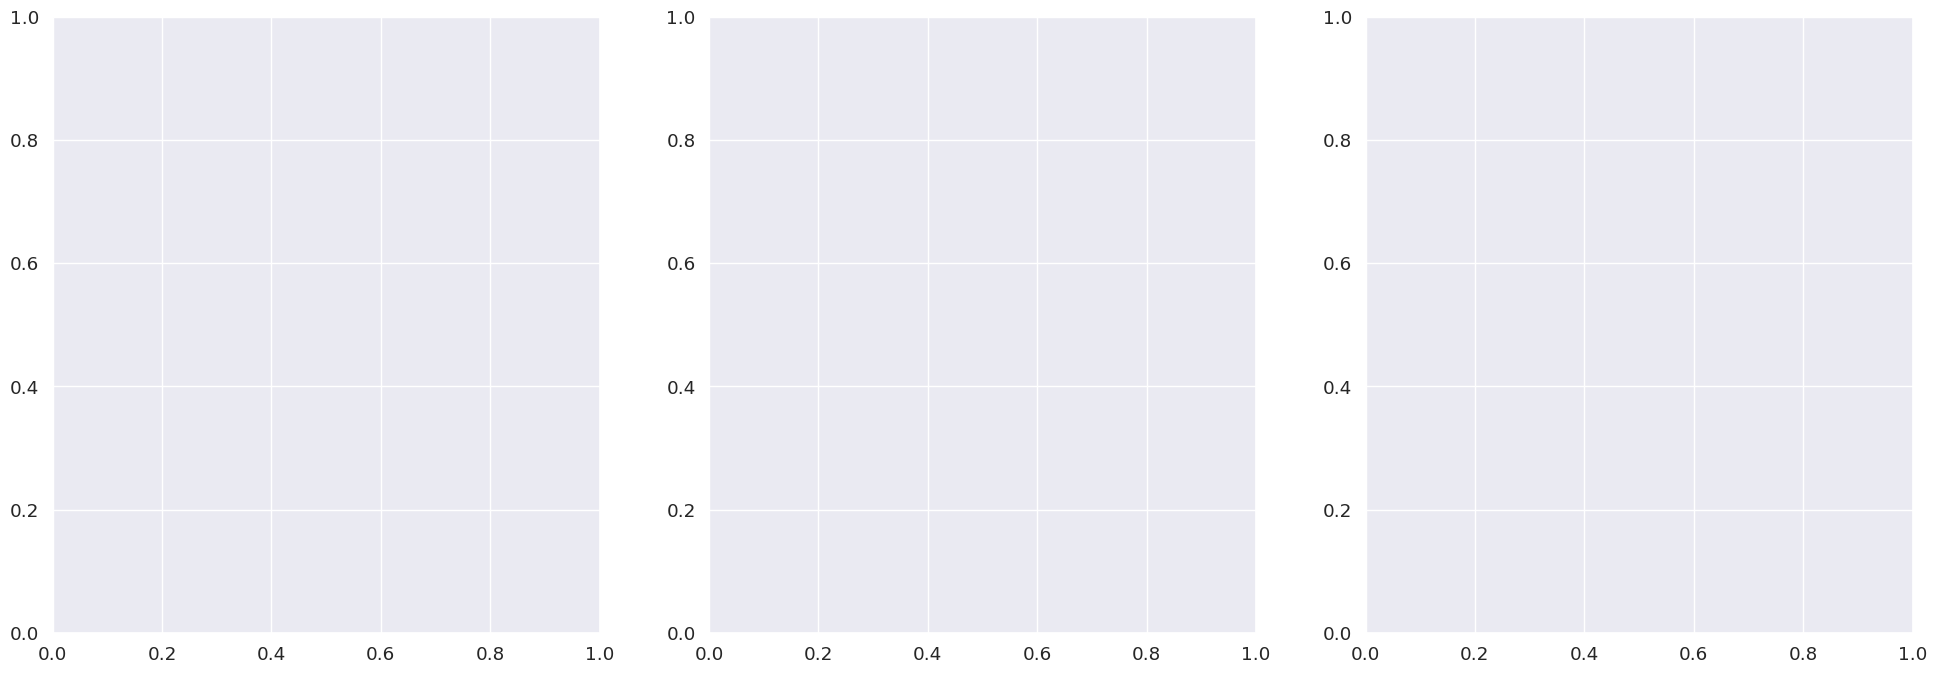

In [8]:
# -*- coding: utf-8 -*-
"""
File: analysis_and_reporting.py
Desc: Loads saved artifacts (models, logs, XAI data) from the
      ChurnGuard AI pipeline and generates all plots and analyses
      for the final project report.

      This script is focused on generating the "evidence"
      for the academic report.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import math

# --- Import SHAP ---
try:
    import shap
    print("SHAP library loaded for plotting.")
except ImportError:
    print("SHAP not installed. XAI plots will be skipped.")
    shap = None

# --- Configuration ---
DATA_DIR = Path("./churn_data")
ARTIFACT_DIR = Path("./churn_artifacts")
REPORT_FIGURE_DIR = Path("./report_figures")
REPORT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
plt.style.use('ggplot')
sns.set_palette('colorblind')

# --- Helper Functions ---
def load_artifacts():
    """Loads all necessary artifacts from the artifact directory."""
    print(f"--- Loading Artifacts from {ARTIFACT_DIR} ---")
    artifacts = {}
    try:
        # --- Load Data Generator Output (for data eval) ---
        artifacts['raw_customers'] = pd.read_csv(DATA_DIR / "customers.csv")
        artifacts['raw_interactions'] = pd.read_csv(DATA_DIR / "interactions.csv")

        # --- Load Pipeline Artifacts ---
        artifacts['agent_log'] = pd.read_csv(ARTIFACT_DIR / "agent_simulation_log.csv")
        artifacts['feature_cols'] = joblib.load(ARTIFACT_DIR / "feature_cols.joblib")
        artifacts['target_encoder'] = joblib.load(ARTIFACT_DIR / "target_encoder.joblib")

        # --- Load Model Test Data ---
        artifacts['X_test_seq'] = joblib.load(ARTIFACT_DIR / "X_test_seq.joblib")
        artifacts['y_test_seq'] = joblib.load(ARTIFACT_DIR / "y_test_seq.joblib")

        # --- Load Models ---
        artifacts['model_mlp'] = joblib.load(ARTIFACT_DIR / "MLPClassifier_churn_model.joblib")
        # PyTorch models
        artifacts['model_lstm_statedict'] = torch.load(ARTIFACT_DIR / "LSTM_Churn_best.pth")
        artifacts['model_transformer_statedict'] = torch.load(ARTIFACT_DIR / "Transformer_Churn_best.pth")

        # --- Load Training History ---
        artifacts['history_lstm'] = joblib.load(ARTIFACT_DIR / "LSTM_Churn_train_history.joblib")
        artifacts['history_transformer'] = joblib.load(ARTIFACT_DIR / "Transformer_Churn_train_history.joblib")

        # --- Load SHAP values ---
        if shap:
            if (ARTIFACT_DIR / "shap_values_mlp.joblib").exists():
                artifacts['shap_values_mlp'] = joblib.load(ARTIFACT_DIR / "shap_values_mlp.joblib")
                artifacts['shap_test_sample_mlp'] = joblib.load(ARTIFACT_DIR / "shap_test_sample_mlp.joblib")
            if (ARTIFACT_DIR / "shap_values_lstm.joblib").exists():
                artifacts['shap_values_lstm'] = joblib.load(ARTIFACT_DIR / "shap_values_lstm.joblib")
                artifacts['shap_test_sample_lstm'] = joblib.load(ARTIFACT_DIR / "shap_test_sample_lstm.joblib")
            if (ARTIFACT_DIR / "shap_values_transformer.joblib").exists():
                artifacts['shap_values_transformer'] = joblib.load(ARTIFACT_DIR / "shap_values_transformer.joblib")
                artifacts['shap_test_sample_transformer'] = joblib.load(ARTIFACT_DIR / "shap_test_sample_transformer.joblib")

        print("All artifacts loaded successfully.")
    except FileNotFoundError as e:
        print(f"Error loading artifact: {e}. Did `churnguard_ai.py` run successfully?")
        return None
    return artifacts

def save_plot(fig, filename):
    """Saves a matplotlib figure to the report directory."""
    path = REPORT_FIGURE_DIR / filename
    fig.savefig(path, dpi=300, bbox_inches='tight')
    print(f"Saved plot: {path}")
    plt.close(fig)

# --- Re-define PyTorch Models (for loading state_dict) ---
# We must define the classes exactly as they were during training.
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.3):
        super().__init__(); self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout); self.dropout = nn.Dropout(dropout); self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        lstm_out, _ = self.lstm(x); last_output = lstm_out[:, -1, :]; out = self.dropout(last_output); out = self.fc(out); return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__(); self.dropout = nn.Dropout(p=dropout); pe = torch.zeros(max_len, d_model); position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1); div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)); pe[:, 0::2] = torch.sin(position * div_term); pe[:, 1::2] = torch.cos(position * div_term); pe = pe.unsqueeze(0).transpose(0, 1); self.register_buffer('pe', pe)
    def forward(self, x): x = x + self.pe[:x.size(0), :]; return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim, dropout=0.3):
        super().__init__(); self.model_type = 'Transformer'; self.input_embed = nn.Linear(input_dim, d_model); self.pos_encoder = PositionalEncoding(d_model, dropout); encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout, batch_first=True); self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers); self.d_model = d_model; self.decoder = nn.Linear(d_model, output_dim)
    def forward(self, src):
        src = self.input_embed(src) * math.sqrt(self.d_model); src = src.permute(1, 0, 2); src = self.pos_encoder(src); src = src.permute(1, 0, 2); output = self.transformer_encoder(src); output = output[:, 0, :]; output = self.decoder(output); return output
# --- End of Model Definitions ---


# --- 1. Synthetic Data Evaluation Plots (NEW) ---
def generate_data_distribution_plots(artifacts):
    """Generates plots to evaluate the synthetic data."""
    print("\n--- 1. Generating Synthetic Data Evaluation Plots ---")
    df_cust = artifacts['raw_customers']
    df_inter = artifacts['raw_interactions']

    # Plot 1: Persona Distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(y='persona', data=df_cust, ax=ax, order=df_cust['persona'].value_counts().index, palette='pastel')
    ax.set_title('Distribution of Customer Personas (Synthetic Data)')
    ax.set_xlabel('Count of Customers')
    ax.set_ylabel('Persona')
    save_plot(fig, "fig_1_data_persona_dist.png")

    # Plot 2: Purchase Value Distribution (Evidence for skew)
    purchase_data = df_inter[df_inter['interaction_type'] == 'purchase']['value']
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(purchase_data, kde=True, ax=ax, bins=50, color='blue')
    ax.set_title('Distribution of Purchase Values (Synthetic Data)')
    ax.set_xlabel('Purchase Value ($)')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, purchase_data.quantile(0.95)) # Clip outliers for better viz
    save_plot(fig, "fig_2_data_purchase_dist.png")

    # Plot 3: Support Tickets Over Time
    df_inter['date'] = pd.to_datetime(df_inter['date'])
    tickets_over_time = df_inter[df_inter['interaction_type'] == 'support_ticket'].groupby('date').size().reset_index(name='ticket_count')
    fig, ax = plt.subplots(figsize=(12, 6))
    tickets_over_time.plot(x='date', y='ticket_count', ax=ax, legend=False)
    ax.set_title('Volume of Support Tickets Over Time (Synthetic Data)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Ticket Count')
    save_plot(fig, "fig_3_data_tickets_over_time.png")

# --- 2. Model Performance Analysis (RQ1) ---
def generate_model_performance_plots(artifacts):
    """Generates and saves plots related to model performance."""
    print("\n--- 2. Generating Model Performance Plots (RQ1) ---")

    y_test = artifacts['y_test_seq']
    X_test_seq = artifacts['X_test_seq']
    X_test_laststep = X_test_seq[:, -1, :]
    # Handle class names properly - convert to strings if they're boolean
    raw_class_names = artifacts['target_encoder'].classes_
    class_names = ['Not Churn', 'Churn']  # Use readable labels instead

    # --- Load Models ---
    input_dim = X_test_seq.shape[2]
    num_classes = len(class_names)

    model_mlp = artifacts['model_mlp']

    model_lstm = LSTMClassifier(input_dim, 128, num_classes)
    model_lstm.load_state_dict(artifacts['model_lstm_statedict'])
    model_lstm.eval()

    model_transformer = TransformerClassifier(input_dim, 128, 4, 2, num_classes)
    model_transformer.load_state_dict(artifacts['model_transformer_statedict'])
    model_transformer.eval()

    # --- Get Predictions ---
    y_pred_mlp = model_mlp.predict(X_test_laststep)
    y_prob_mlp = model_mlp.predict_proba(X_test_laststep)[:, 1]

    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
        y_prob_lstm_tensor = model_lstm(X_test_tensor).softmax(dim=1)
        y_prob_lstm = y_prob_lstm_tensor.numpy()[:, 1]
        y_pred_lstm = np.argmax(y_prob_lstm_tensor.numpy(), axis=1)

        y_prob_trans_tensor = model_transformer(X_test_tensor).softmax(dim=1)
        y_prob_trans = y_prob_trans_tensor.numpy()[:, 1]
        y_pred_trans = np.argmax(y_prob_trans_tensor.numpy(), axis=1)

    # --- Plot 1: Confusion Matrices ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))
    sns.set(font_scale=1.2)

    # Helper function to safely get F1 score for churn class
    def get_churn_f1(report_dict):
        # Try different possible keys for the churn class
        possible_keys = [1, '1', True, 'True', np.True_]
        for key in possible_keys:
            if key in report_dict and 'f1-score' in report_dict[key]:
                return report_dict[key]['f1-score']
        # If none found, return 0
        return 0.0

    cm_mlp = confusion_matrix(y_test, y_pred_mlp)
    report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True, zero_division=0)
    sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=class_names, yticklabels=class_names)
    f1_churn_mlp = get_churn_f1(report_mlp)
    axes[0].set_title(f'CM: MLPClassifier\nF1(Churn): {f1_churn_mlp:.3f}')

    cm_lstm = confusion_matrix(y_test, y_pred_lstm)
    report_lstm = classification_report(y_test, y_pred_lstm, output_dict=True, zero_division=0)
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=class_names, yticklabels=class_names)
    f1_churn_lstm = get_churn_f1(report_lstm)
    axes[1].set_title(f'CM: LSTM\nF1(Churn): {f1_churn_lstm:.3f}')

    cm_trans = confusion_matrix(y_test, y_pred_trans)
    report_trans = classification_report(y_test, y_pred_trans, output_dict=True, zero_division=0)
    sns.heatmap(cm_trans, annot=True, fmt='d', cmap='Oranges', ax=axes[2], xticklabels=class_names, yticklabels=class_names)
    f1_churn_trans = get_churn_f1(report_trans)
    axes[2].set_title(f'CM: Transformer\nF1(Churn): {f1_churn_trans:.3f}')

    fig.suptitle('RQ1: Model Performance Comparison (Confusion Matrices)', fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_plot(fig, "fig_4_confusion_matrices.png")

    # --- Plot 2: ROC Curves ---
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
    auc_mlp = auc(fpr_mlp, tpr_mlp)

    fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_lstm)
    auc_lstm = auc(fpr_lstm, tpr_lstm)

    fpr_trans, tpr_trans, _ = roc_curve(y_test, y_prob_trans)
    auc_trans = auc(fpr_trans, tpr_trans)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.3f})', lw=2)
    ax.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.3f})', lw=2)
    ax.plot(fpr_trans, tpr_trans, label=f'Transformer (AUC = {auc_trans:.3f})', lw=3, linestyle='--')
    ax.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('RQ1: Model ROC Curve Comparison')
    ax.legend()
    save_plot(fig, "fig_5_roc_curves.png")

    # --- Plot 3: Training/Validation Loss Curves (NEW) ---
    history_lstm = artifacts['history_lstm']
    history_transformer = artifacts['history_transformer']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # LSTM Loss
    axes[0].plot(history_lstm['train_loss'], label='Train Loss')
    axes[0].plot(history_lstm['val_loss'], label='Validation Loss')
    axes[0].set_title('LSTM: Training & Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Cross-Entropy Loss')
    axes[0].legend()

    # Transformer Loss
    axes[1].plot(history_transformer['train_loss'], label='Train Loss')
    axes[1].plot(history_transformer['val_loss'], label='Validation Loss')
    axes[1].set_title('Transformer: Training & Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Cross-Entropy Loss')
    axes[1].legend()

    fig.suptitle('RQ1: Model Training Curves', fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_plot(fig, "fig_6_training_loss_curves.png")

# --- 3. XAI Analysis Plots (RQ2) ---
def generate_xai_plots(artifacts):
    """Generates and saves plots from the XAI analysis."""
    if shap is None: return
    print("\n--- 3. Generating XAI Plots (RQ2) ---")

    feature_names = artifacts['feature_cols']
    # Use readable class names instead of raw encoded values
    class_names = ['Not Churn', 'Churn']
    churn_class_index = 1 # Assuming 'Churn' is class 1

    fig, axes = plt.subplots(1, 3, figsize=(24, 8)) # One plot for each model

    # --- MLP SHAP Plot ---
    if 'shap_values_mlp' in artifacts:
        shap_values_mlp = artifacts['shap_values_mlp']
        test_sample_mlp = artifacts['shap_test_sample_mlp']
        df_test_sample_mlp = pd.DataFrame(test_sample_mlp, columns=feature_names)

        shap.summary_plot(shap_values_mlp[churn_class_index], df_test_sample_mlp,
                          plot_type="bar", feature_names=feature_names, show=False, max_display=15,
                          ax=axes[0])
        axes[0].set_title(f"MLP (Predicting '{class_names[churn_class_index]}')")

    # --- LSTM SHAP Plot ---
    if 'shap_values_lstm' in artifacts:
        shap_values_lstm = artifacts['shap_values_lstm']
        test_sample_lstm = artifacts['shap_test_sample_lstm']

        # Aggregate SHAP values across the time dimension (axis 1)
        agg_shap_values = np.mean(np.abs(shap_values_lstm[churn_class_index]), axis=1)
        df_test_sample_lstm = pd.DataFrame(test_sample_lstm[:, -1, :], columns=feature_names) # Use last day's features

        # Create a new SHAP summary plot on axes[1]
        shap.summary_plot(agg_shap_values, df_test_sample_lstm, feature_names=feature_names,
                          plot_type="bar", show=False, max_display=15,
                          ax=axes[1])
        axes[1].set_title(f"LSTM (Predicting '{class_names[churn_class_index]}', Avg over Time)")

    # --- Transformer SHAP Plot ---
    if 'shap_values_transformer' in artifacts:
        shap_values_transformer = artifacts['shap_values_transformer']
        test_sample_transformer = artifacts['shap_test_sample_transformer']

        agg_shap_values_trans = np.mean(np.abs(shap_values_transformer[churn_class_index]), axis=1)
        df_test_sample_trans = pd.DataFrame(test_sample_transformer[:, -1, :], columns=feature_names)

        shap.summary_plot(agg_shap_values_trans, df_test_sample_trans, feature_names=feature_names,
                          plot_type="bar", show=False, max_display=15,
                          ax=axes[2])
        axes[2].set_title(f"Transformer (Predicting '{class_names[churn_class_index]}', Avg over Time)")

    fig.suptitle('RQ2: Global Feature Importance (SHAP Values)', fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_plot(fig, "fig_7_shap_summary_comparison.png")

    # --- Temporal Importance Plot (NEW) ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    if 'shap_values_lstm' in artifacts:
        shap_values_lstm = artifacts['shap_values_lstm']
        temporal_importance_lstm = np.mean(np.abs(shap_values_lstm[churn_class_index]), axis=(0, 2))

        axes[0].plot(range(len(temporal_importance_lstm)), temporal_importance_lstm, marker='o', linestyle='--', color='green')
        axes[0].set_title('LSTM: Temporal Importance')
        axes[0].set_xlabel(f'Time Step (Day T-{len(temporal_importance_lstm)-1} to T-0)')
        axes[0].set_ylabel('Mean |SHAP Value| (Aggregated across features)')
        axes[0].set_xticks(range(len(temporal_importance_lstm)))

    if 'shap_values_transformer' in artifacts:
        shap_values_transformer = artifacts['shap_values_transformer']
        temporal_importance_trans = np.mean(np.abs(shap_values_transformer[churn_class_index]), axis=(0, 2))

        axes[1].plot(range(len(temporal_importance_trans)), temporal_importance_trans, marker='s', linestyle='--', color='orange')
        axes[1].set_title('Transformer: Temporal Importance')
        axes[1].set_xlabel(f'Time Step (Day T-{len(temporal_importance_trans)-1} to T-0)')
        axes[1].set_ylabel('Mean |SHAP Value|')
        axes[1].set_xticks(range(len(temporal_importance_trans)))

    fig.suptitle('RQ2: Temporal Feature Importance (SHAP Values)', fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_plot(fig, "fig_8_shap_temporal_importance.png")

# --- 4. Agent Evaluation Plots ---
def generate_agent_evaluation_plots(artifacts):
    """Generates and saves plots related to the agent simulation."""
    print("\n--- 4. Generating Agent Evaluation Plots ---")
    df_log = artifacts['agent_log']

    if df_log.empty:
        print("Agent log is empty. Skipping plots.")
        return

    # --- Plot 1: Simulated ROI ---
    LTV = 100 # Mock $100 LTV for a churning customer
    df_log['simulated_revenue_at_risk'] = df_log['ground_truth_churn'].apply(lambda x: LTV if x else 0)

    df_log['net_revenue_saved'] = df_log.apply(
        lambda row: (row['simulated_revenue_at_risk'] - row['agent_cost']) if row['simulated_outcome_success'] else (-row['agent_cost']),
        axis=1
    )

    # --- Compare Strategies ---
    net_profit_do_nothing = 0
    net_profit_agent = df_log['net_revenue_saved'].sum()

    # Simple Strategy: $5 coupon for *all* high-risk customers
    simple_strategy_cost = len(df_log) * 5
    # Assume 15% success rate on *actual* churners
    simple_strategy_success_count = (df_log['ground_truth_churn'] * (np.random.rand(len(df_log)) < 0.15)).sum()
    net_profit_simple_strategy = (simple_strategy_success_count * LTV) - simple_strategy_cost

    roi_data = {
        'Strategy': ['Do Nothing', 'Simple Coupon (Broad)', 'ChurnGuard AI (Targeted)'],
        'Net Simulated Profit ($)': [net_profit_do_nothing, net_profit_simple_strategy, net_profit_agent]
    }
    df_roi = pd.DataFrame(roi_data)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Strategy', y='Net Simulated Profit ($)', data=df_roi, ax=ax, palette='viridis')
    ax.set_title(f'Agent vs. Baseline Strategies: Simulated Net Profit on {len(df_log)} High-Risk Customers')
    save_plot(fig, "fig_9_simulated_roi.png")

    # --- Plot 2: Intervention Action Distribution ---
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.countplot(y='agent_action', data=df_log, order=df_log['agent_action'].value_counts().index, palette='crest')
    ax.set_title('Distribution of AI-Generated Retention Actions')
    ax.set_xlabel('Count')
    ax.set_ylabel('Action')
    save_plot(fig, "fig_10_agent_action_distribution.png")

# --- Main Execution ---
if __name__ == "__main__":

    artifacts = load_artifacts()

    if artifacts:
        # 1. Generate Data Eval Plots
        generate_data_distribution_plots(artifacts)

        # 2. Generate Model Performance Plots (RQ1)
        generate_model_performance_plots(artifacts)

        # 3. Generate XAI Plots (RQ2)
        generate_xai_plots(artifacts)

        # 4. Generate Agent Evaluation Plots
        generate_agent_evaluation_plots(artifacts)

        print("\n--- All Analysis and Reporting Complete ---")
        print(f"All figures saved to: {REPORT_FIGURE_DIR}")
    else:
        print("Could not load artifacts. Exiting reporting script.")

In [ ]:
# Source - https://stackoverflow.com/a
# Posted by Shashank Mishra
# Retrieved 2025-11-22, License - CC BY-SA 4.0
from google.colab import files
!zip -r /content/churn_artifacts . -i /content/churn_artifacts.zip
files.download("/content/churn_artifacts.zip")